# Task 1

Design a quantum circuit that considers as input the following vector of integers numbers:
[1,5,7,10]
and returns a quantum state which is a superposition of indices of the target solution, obtaining in the output the indices of the inputs where two adjacent bits will always have different values.

### Bonus:

Design a general circuit that accepts vectors with random values of size $2^n$ with m bits in length for each element and finds the state(s) indicated above from an oracle.


# Solution:

A method has been introduced here that takes a general vector of size $2^n$ (including the vector given in task). 

## Method :
- Step 1 : Take the vector and produce a binary value of each corresponding element and then identify the elements with alternating bits[Alterbits, does this job].
- Step 2 : Store the position of identified elements into a list(the will be useful later).[Altpos, does this job]
- Step 3 : Use Grover's Algorithm to find those identified elements.

## Grover's algorithm:
#### Theory : 
Grover's Algorithm is used to do searching of elements from an unstructured List of items. It basically takes in the length of list($2^n$ where n is no. of qubits) to obtain a superposition of all qubits(call it s from here), it then creates another state orthogonal(call it s') to the state representing identified positions(call it w) by simply subracting w from s. Next it reflects the state s about s' (basically flipping the amplitude of bits corresponding to w in s and thereby reducing the average amplitude of s), finally it takes this new state and reflects it about s to create a new state closer to w. It repeats thiss process of reflection about s' and s alteratively till it almost completely overlaps with w. In other words we have now obtained the state representing w.

#### Definitions
- Alterbits : Takes in the vector converts it into binary and then compares the adjacent bits for a given vector element. All the elements from the vector will have same bit length as the minimum number of bits required to represent the maximun valued element from the list. The implication of this is that while 2 can be considered to have alternating bits for bit length 2 and 3, it is not if an element 8 or greater is alsso present in the list. 
- Altpos : Selects those vector element that have alternating bits and saves their position into a new vector w. 
- oracle : oracle creates a gate that can perform the reflection about the state s', by defining a daigonal matrix that when applied to the state s return negative sign infront of states corresponding to w. (But we cannot measure this yet because this negative sign does not appear in the measurement as the state itself is not an observable, but the probabilities which squares to give all positive hence the information of selected elements will be lost.
- diffuser : the job of diffuser is the perform a reflection of obtained state about s. Its code has been adopted from "Qiskit Textbook, 3.8 Grover's Algorithm, Creating a general diffuser".
- circuit : It creates a Quantum Circuit that creates the superposition states s, applies the oracle and diffuser gates t number of times, measures the state and produce a probability distribution of observed states.

#### Deciding t (How many times oracle and diffuser be applied?)
We require the state after t reflection to align along w $\implies$ it should make an angle $\pi/2$ with state s'. If the starting state s made angle $\theta$ with s' then after t reflections:
$$ \theta_t = (2t + 1)\theta = \pi/2 $$ and $\theta = sin^{-1}\frac{1}{\sqrt(N)}$. N is length of vector.

In [3]:
#Required Imports
import numpy as np
from qiskit import *
import math
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
import random

In [4]:
#to select elements with alternating bits
def Alterbits(n,v):
    c = len("{0:b}".format(max(v))) #chooses the length of bits for all elements based on minimum requirement for the maximum element in the list
    bits = '{0:0{p}b}'.format(n, p=c)
    return all(bits[i] != bits[i+1]
                for i in range(c - 1))

In [5]:
#to store the postion of selected elements 
def Altpos(w,v):
    for i in range(len(v)):
        if Alterbits(v[i],v) is True :
            w.append(i)

In [19]:
#for reflection about orthogonal state s'
def oracle(w,v):
    operator = np.identity(2**num_qubits)
    for i in w:
        operator[i][i] = operator[i][i]*(-1) #to generate an operator matrix to achieve the reflection
    qc = QuantumCircuit(num_qubits, name = "Oracle")
    qubit_list = list(range(num_qubits))
    qc.unitary(operator,list(range(num_qubits))) #directly uses the matrix in circuit using unitary method
    qc.to_gate() 
    return qc

In [20]:
#for reflection about s
def diffuser():
    cir = QuantumCircuit(num_qubits, name = 'Amplifier')
    cir.h(list(range(num_qubits)))
    cir.x(list(range(num_qubits)))
    cir.h(num_qubits-1)
    cir.mct(list(range(num_qubits-1)),num_qubits-1)  
    cir.h(num_qubits-1)
    cir.x(list(range(num_qubits)))
    cir.h(list(range(num_qubits)))
    cir.to_gate()
    return cir

In [21]:
#to bring all componets together 
def circuit(v):
    x = math.log10(len(v))/math.log10(2) #to check if length of vector if of 2^n form 
    if math.ceil(x) == math.floor(x) :
        w = []
        Altpos(w,v)
        if len(w) == 0:
            print("No element in the list",v," has alternating bits") #if no element in the list have alternating bits
        else:
            qcir = QuantumCircuit(num_qubits)
            qcir.h(list(range(num_qubits)))
            t = int((np.pi/(4*math.asin(1/np.sqrt(num_qubits)))+1/2))
            for i in range(t):
                qcir.append(oracle(w,v),list(range(num_qubits)))
                qcir.append(diffuser(), list(range(num_qubits)))
            qcir.measure_all()
            display(qcir.draw())
            aer_sim = Aer.get_backend('aer_simulator')
            transpiled_grover_circuit = transpile(qcir, aer_sim)
            qobj = assemble(transpiled_grover_circuit)
            results = aer_sim.run(qobj).result()
            counts = results.get_counts()  
            display(plot_histogram(counts))
            display(v)
    else:
        print("Vector length:",num_qubits,",is not a power of two")

In [22]:
#r = int(input("Enter the upper range for the vector"))  
#m = int(input("Enter the length in 2^m of vector"))
#v = random.sample(range(r),2**m)  #to produce a random vector just remove the coments in this section and delete the defined vector below 
v = [2,5,6,10,0,9,1,3]

┌───┐┌─────────┐┌────────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0        ├┤0           ├─░─┤M├──────
        ├───┤│         ││            │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Oracle ├┤1 Amplifier ├─░──╫─┤M├───
        ├───┤│         ││            │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2        ├┤2           ├─░──╫──╫─┤M├
        └───┘└─────────┘└────────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

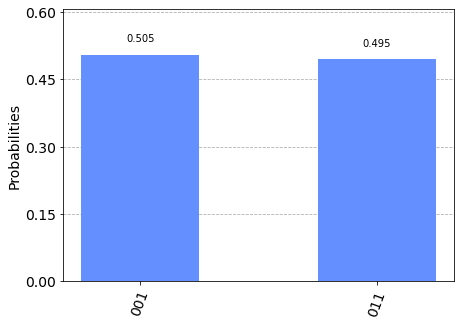

[2, 5, 6, 10, 0, 9, 1, 3]

In [23]:
if (len(v)<=4): #note : if the length of vector is 4 or less and if the selected elements from vector having alternating qubits is more than 1 then minimum 3 qubits are required.
    num_qubits = 3
elif (len(v)>4):
    num_qubits = int(math.log10(len(v))/math.log10(2))
circuit(v)